# Implementación en JAX de una CNN para clasificar la base de datos Fashion MNIST
______________________________________________

## ¿Qué es JAX?

JAX es una librería de Python diseñada para facilitar la investigación en machine learning, la cual nos permite crear arreglos multidimensionales y realizar operaciones con ellos. Además, permite calcular la diferenciación automática de funciones en Python y puede utilizar el compilador XLA (Accelerated Linear Algebra) para fusionar múltiples operaciones y así acelerar las operaciones y reducir el tiempo de ejecución de las mismas.

En resumen, las características importantes de JAX son las siguientes:
    
- API similar a Numpy en CPU/GPU/TPU.
- Diferenciación Automática.
- XLA + compilación Just-In-Time (JIT) para una ejecución más rápida.
______________________________________________

## CNN

Importamos JAX e imprimimos la versión:

In [1]:
import jax

print("JAX Version : {}".format(jax.__version__))

JAX Version : 0.4.28


Importamos los submódulos `stax` y `optimizers` para crear redes neuronales y optimizadores respectivamente, mientras que el módulo `jax.numpy` nos ayudará a crear arreglos.

In [2]:
from jax.example_libraries import stax, optimizers
from jax import numpy as jnp

### Fashion MNIST Dataset

La base de datos tiene imágenes de 28x28 pixeles en escala de grises de 10 tipos de prendas diferentes. Los datos ya se encuentran divididos en dos conjuntos: entrenamiento con 60,000 muestras y prueba con 10,000 muestras.

| Etiqueta | Descripción |
|:---------|:-----------:|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Importamos la base de datos:

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# Cargamos los datos
(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

# Convertimos los datos de matrices de numpy a matrices en JAX.
X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32)


# Redimensionamos las imágenes cargadas a (28,28,1) donde la última dimensión representa el canal de color.
X_train, X_test = X_train.reshape(-1,28,28,1), X_test.reshape(-1,28,28,1)

# Normalizamos los datos acorde al rango manejado por la escala de grises (0,255).
X_train, X_test = X_train/255.0, X_test/255.0

# Obtenemos las clases.
classes =  jnp.unique(Y_train)

print("Los conjuntos tienen las siguientes dimensiones:")
print("\n")
print("    - Entrenamiento:", X_train.shape)
print("    - Etiquetas:", Y_train.shape)
print("\n")
print("    - Prueba:", X_test.shape)
print("    - Etiquetas:", Y_test.shape)

2024-06-02 14:09:54.242453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Los conjuntos tienen las siguientes dimensiones:


    - Entrenamiento: (60000, 28, 28, 1)
    - Etiquetas: (60000,)


    - Prueba: (10000, 28, 28, 1)
    - Etiquetas: (10000,)


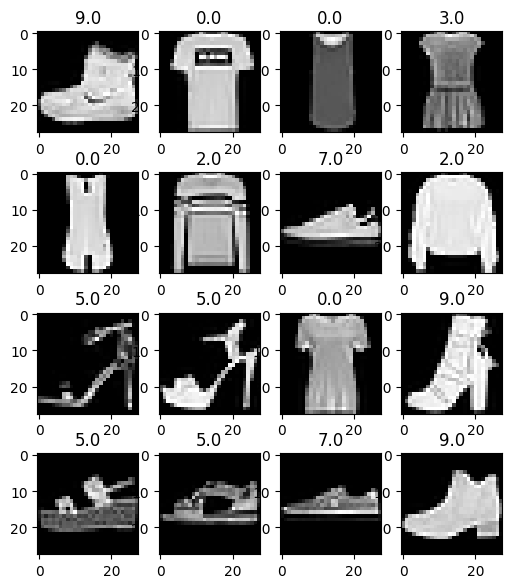

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 4, figsize=(6, 7))

img_num = 0
for i in range(0,4):
    for j in range(0,4):
        ax[i][j].imshow(X_train[img_num], cmap = 'binary_r')
        ax[i][j].set_title(Y_train[img_num])
        img_num += 1

## Definir CNN

Definimos una red neuronal convolucional que utilizaremos para la clasificación de imágenes de nuestro conjunto de datos. Consistirá de 2 capas de convolución y una capa densa.

In [5]:
conv_init, conv_apply = stax.serial(

    # Capa de convolución con 16 canales y kernel de (3,3).
    # 'SAME' padding para que el largo y ancho de la entrada y salida sean iguales.
    stax.Conv(16,(3,3), padding="SAME"),
    stax.Relu,

    # Capa de convolución con 8 canales y kernel de (3,3).
    # 'SAME' padding para que el largo y ancho de la entrada y salida sean iguales.
    stax.Conv(8, (3,3), padding="SAME"),
    stax.Relu,

    # Aplanamos la salida en un vector de 28 x 28 x 8 = 6272 entradas.
    stax.Flatten,

    # Agregamos una capa densa con tamaño igual al número de clases, que es de 10.
    stax.Dense(len(classes)),
    # Aplicamos la función de activación Softmax.
    stax.Softmax

)

<img src="CNN_Architecture.png" width="395" height="345"/>

- La primer capa transforma una imagen de 1 a 16 canales.
- La segunda capa transforma la imagen de 16 a 8 canales.
- La altura y anchura de la imagen para ambas capas no se altera, para este caso 28x28.
- Después de cada capa de convolución se aplica la función de activación Relu.
- Se aplana el resultado de las dos convoluciones y se aplica la función de activación Softmax.

Después de aplicar la función de activación Softmax, se mapean los valores de salida dentro del rango [0,1]. Luego, se puede predecir la clase de la imagen como aquella con el valor más alto de esos 10 valores obtenidos.

Ahora, `conv_init` permite inicializar los pesos de la red.

In [6]:
# Se establece una semilla para generar valores pseudo-aleatorios.
rng = jax.random.PRNGKey(123)

# Se inicializan los pesos.
weights = conv_init(rng, (256,28,28,1))
weights = weights[1]

for w in weights:
    if w:
        w, b = w
        print("Weights : {}, Biases : {}".format(w.shape, b.shape))

Weights : (3, 3, 1, 16), Biases : (1, 1, 1, 16)
Weights : (3, 3, 16, 8), Biases : (1, 1, 1, 8)
Weights : (6272, 10), Biases : (10,)


Por otro lado, `conv_apply` permite pasar un elemento a través de la red.

In [7]:
preds = conv_apply(weights, X_train[:1])

preds

Array([[0.08278142, 0.05468908, 0.07020646, 0.1121063 , 0.07269911,
        0.11624244, 0.11827588, 0.11555161, 0.1255018 , 0.13194594]],      dtype=float32)

Para realizar una predicción usamos la función `argmax()`:

Nuestra predicción es: 9
El valor real es: 9


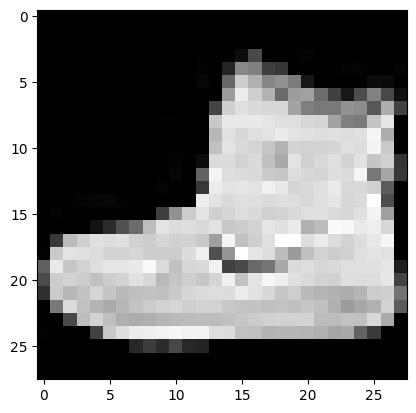

In [8]:
print("Nuestra predicción es: {}".format(jnp.argmax(preds)))
print("El valor real es: {}".format(int(Y_train[:1][0])))

plt.imshow(X_train[0], cmap = 'binary_r')

## Función de pérdida

La función de pérdida utilizada es la entropía cruzada categórica o discreta:

$H(p,q) = - \Sigma\ p(x) \ log\ q(x) $

La función toma como variables los pesos, los datos de entrada del conjunto de entrenamiento y los valores reales de las etiquetas. Para implementar la función se realiza lo siguiente:
1. Se realiza una predicción sobre los datos de entrada usando `conv_apply`.
2. Codificamos como _one-hot_ los valores de las etiquetas y multiplicamos por el logaritmo de nuestras predicciones.
3. Calculamos la suma de todos los elementos del arreglo de salida.

In [9]:
from jax import jit

def SlowCrossEntropyLoss(weights, input_data, actual):
    preds = conv_apply(weights, input_data)
    one_hot_actual = jax.nn.one_hot(actual, num_classes=len(classes))
    log_preds = jnp.log(preds)
    return - jnp.sum(one_hot_actual * log_preds)

CrossEntropyLoss = jax.jit(SlowCrossEntropyLoss)

## Predicciones

Definimos una función que recorre los datos de entrenamiento o prueba en lotes y realiza predicciones de clase para cada muestra. La CNN da como resultado 10 valores por muestra, entonces para predecir la clase se emplea el valor máximo de los 10 resultados obtenidos, el cual puede calcularse con ayuda de la función `argmax()`.

In [10]:
def MakePredictions(weights, input_data, batch_size):

    # Definimos índices de los lotes.
    batches = jnp.arange( (input_data.shape[0]//batch_size) + 1 )

    preds = []
    for batch in batches:
        if batch != batches[-1]:
            start, end = int( batch * batch_size ), int( batch * batch_size + batch_size )
        else:
            start, end = int( batch * batch_size ), None

        # Definimos un lote de datos.
        X_batch = input_data[start:end]

        # Registramos predicciones del lote.
        if X_batch.shape[0] != 0:
            preds.append( conv_apply(weights, X_batch) )

    # Combinar predicciones de todo el lote.
    preds = jnp.concatenate(preds).squeeze()

    # Calculamos predicción
    preds = jnp.argmax(preds, axis=1)

    return preds

## Entrenar la red

Se define un número de épocas, en la que para cada una se calculan los índices de los lotes del conjunto de entrenamiento. Después, al llamar la función `value_and_grad()`, se pasan los datos de cada lote a través de la red para hacer predicciones, calcular la función de pérdida y por último calcular los gradientes de la función de pérdida con respecto a los pesos de la red.

Después de calcular los gradientes, actualizamos los pesos llamando al método `update()` del optimizador. Finalmente, devolvemos el último objeto de estado del optimizador, el cuál tiene los pesos actualizados.

Como parte del proceso, también evaluamos el rendimiento de la red al calcular la precisión de las predicciones, tanto del conjunto de entrenamiento como de validación. 

In [11]:
from jax import value_and_grad
from sklearn.metrics import accuracy_score

# opt_state define el estado actual del optimizador, el cual está relacionado con los pesos de la red.
def TrainModelInBatches(X_train, Y_train, X_test, Y_test, epochs, opt_state, batch_size):

    epoch_losses = []
    epoch_accuracies = []
    for i in range(1, epochs + 1):

        print("_____________Época {}_____________".format(i))

        # Definir índices de los lotes de entrenamiento.
        batches_train = jnp.arange( (X_train.shape[0]//batch_size) + 1 )
        batches_test = jnp.arange( (X_test.shape[0]//batch_size) + 1 )

        losses_train = []
        accuracies_train = []
        for batch_train in batches_train:
            if batch_train != batches_train[-1]:
                start_train, end_train = int( batch_train * batch_size ), int( batch_train * batch_size + batch_size )
            else:
                start_train, end_train = int( batch_train * batch_size ), None

            # Definimos un lote de datos de entrenamiento.
            X_train_batch, Y_train_batch = X_train[start_train:end_train], Y_train[start_train:end_train]

            # Calculamos la función de pérdida y gradientes.
            loss_train, gradients_train = value_and_grad(CrossEntropyLoss)(opt_get_weights(opt_state), X_train_batch,Y_train_batch)

            # Actualizamos los pesos.
            opt_state = opt_update(i, gradients_train, opt_state)

            # Registramos el resultado de la función de pérdida para el lote.
            losses_train.append(loss_train)

            # Realizamos predicciones para el lote de entrenamiento.
            preds_train = MakePredictions(opt_get_weights(opt_state), X_train_batch, batch_size)

            # Calculamos y registramos precisión de las predicciones sobre el lote.
            accuracies_train.append(accuracy_score(Y_train_batch, preds_train))

        losses_test = []
        accuracies_test = []
        for batch_test in batches_test:
            if batch_test != batches_test[-1]:
                start_test, end_test = int( batch_test * batch_size ), int( batch_test * batch_size + batch_size )
            else:
                start_test, end_test = int( batch_test * batch_size ), None

            # Definimos un lote de datos de validación.
            X_test_batch, Y_test_batch = X_test[start_test:end_test], Y_test[start_test:end_test]

            # Calculamos la función de pérdida y gradientes.
            loss_test, gradients_test = value_and_grad(CrossEntropyLoss)(opt_get_weights(opt_state), X_test_batch,Y_test_batch)

            # Registramos el resultado de la función de pérdida para el lote.
            losses_test.append(loss_test)

            # Realizamos predicciones para el lote de prueba.
            preds_test = MakePredictions(opt_get_weights(opt_state), X_test_batch, batch_size)

            # Calculamos y registramos precisión de las predicciones sobre el lote.
            accuracies_test.append(accuracy_score(Y_test_batch, preds_test))

        epoch_losses.append((jnp.array(losses_train).mean(),jnp.array(losses_test).mean()))
        epoch_accuracies.append((jnp.array(accuracies_train).mean(),jnp.array(accuracies_test).mean()))

        print("Train CrossEntropyLoss: {:.3f}".format(jnp.array(losses_train).mean()))
        print("Test CrossEntropyLoss: {:.3f}".format(jnp.array(losses_test).mean()))
        print("\n")
        print("Train Accuracy: {:.3f}".format(jnp.array(accuracies_train).mean()))
        print("Test Accuracy: {:.3f}".format(jnp.array(accuracies_test).mean()))
        print("__________________________________")

    return opt_state,epoch_losses,epoch_accuracies

Creamos un optimizador del tipo SGD utilizando el módulo `optimizers` y definiendo una tasa de aprendizaje.

El optimizador devuelve tres funciones:
- `init()`: Define el estado inicial del optimizador, dados los pesos inicialmente proporcionados a la red.
- `update()`: Para actualizar los pesos del optimizador al recibir un estado previo y el cálculo de los gradientes.
- `get_weights()`: Para obtener los pesos del estado actual del optimizador.

In [12]:
# Definimos la tasa de aprendizaje, el número de épocas y el tamaño del lote.
learning_rate = jnp.array(1/1e4)
epochs = 25
batch_size = 256

# Inicializamos pesos.
weights = conv_init(rng, (batch_size,28,28,1))
weights = weights[1]

# Obtenemos funciones del optimizador.
opt_init, opt_update, opt_get_weights = optimizers.sgd(learning_rate)

# Obtenemos el estado inicial del optimizador.
opt_state = opt_init(weights)

# Entrenamos la red y obtenemos el estado final del optimizador junto con los resultados de la función de pérdida y precisión.
final_opt_state, CNN_losses, CNN_accuracies = TrainModelInBatches(X_train, Y_train, X_test, Y_test, epochs, opt_state, batch_size)

_____________Época 1_____________
Train CrossEntropyLoss: 229.157
Test CrossEntropyLoss: 147.609


Train Accuracy: 0.721
Test Accuracy: 0.795
__________________________________
_____________Época 2_____________
Train CrossEntropyLoss: 147.877
Test CrossEntropyLoss: 133.821


Train Accuracy: 0.808
Test Accuracy: 0.810
__________________________________
_____________Época 3_____________
Train CrossEntropyLoss: 129.923
Test CrossEntropyLoss: 123.728


Train Accuracy: 0.832
Test Accuracy: 0.826
__________________________________
_____________Época 4_____________
Train CrossEntropyLoss: 119.195
Test CrossEntropyLoss: 116.135


Train Accuracy: 0.847
Test Accuracy: 0.838
__________________________________
_____________Época 5_____________
Train CrossEntropyLoss: 111.270
Test CrossEntropyLoss: 110.103


Train Accuracy: 0.858
Test Accuracy: 0.848
__________________________________
_____________Época 6_____________
Train CrossEntropyLoss: 104.990
Test CrossEntropyLoss: 105.304


Train Accuracy: 

Llamamos a la función de entrenamiento, proporcionando los conjuntos de datos necesarios y otros parámetros requeridos para entrenar la red. Como resultado, almacenamos el estado final del optimizador, que contiene los pesos calculados para poder realizar predicciones posteriores; y también obtenemos los valores calculados para la función de pérdida y precisión de los conjuntos de entrenamiento y prueba.

## Evaluación del modelo

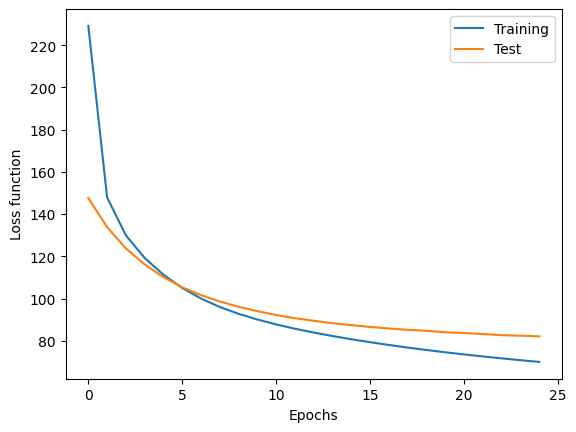

In [13]:
plt.plot(CNN_losses, label = ['Training','Test'] )
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend()

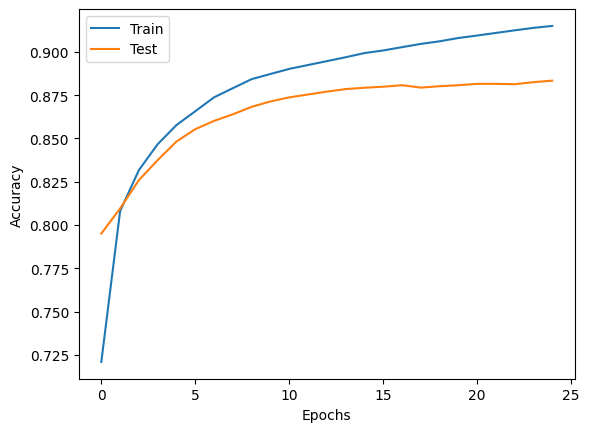

In [14]:
plt.plot(CNN_accuracies, label = ['Train','Test'] )
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Mostramos el reporte de clasificación por clases para los datos del conjunto de prueba:

In [15]:
from sklearn.metrics import classification_report

test_preds = MakePredictions(opt_get_weights(final_opt_state), X_test, batch_size)

print("                    Test Classification Report")
print("______________________________________________________")
print(classification_report(Y_test, test_preds))

                    Test Classification Report
______________________________________________________
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      1000
         1.0       0.99      0.96      0.97      1000
         2.0       0.75      0.89      0.81      1000
         3.0       0.85      0.92      0.88      1000
         4.0       0.86      0.74      0.80      1000
         5.0       0.98      0.95      0.96      1000
         6.0       0.75      0.62      0.68      1000
         7.0       0.93      0.96      0.94      1000
         8.0       0.97      0.97      0.97      1000
         9.0       0.96      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Precisión
    
De todas las instancias que el modelo predijo como positivas, ¿cuántas fueron realmente positivas?

$ Precision = \frac{True\ Positive}{True\ Positive + False\ Positive}$

Una alta precisión indica que el modelo tiene una baja tasa de falsos positivos.

### Recall (Sensibilidad)
De todas las instancias que eran realmente positivas, ¿cuántas identificó correctamente el modelo?

$ Sensibilidad = \frac{True\ Positive}{True\ Positive + False\ Negative}$

Una alta sensibilidad indica que el modelo tiene una baja tasa de falsos negativos.

### F1-Score (Puntuación F1)
Proporciona una única métrica que equilibra tanto los aspectos de la precisión como de la sensibilidad.

$ F1\text{-}Score = 2 \times \frac{Precision \times Recall}{Precision + Recall} $

Una alta puntuación F1 indica que tanto la precisión como la sensibilidad son altas.

|                 | Predicted Positive | Predicted Negative |
|:----------------|:------------------:|:------------------:|
| Actual Positive | True Positive (TP) | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN) |

Entender estas métricas es crucial para evaluar la efectividad de un modelo de clasificación, especialmente cuando se trata de conjuntos de datos desbalanceados.

## Mapa de características

Los mapas de características se obtienen al aplicar los filtros de la red a una imagen de muestra. La idea de visualizar un mapa de características es entender qué características de la imagen se detectan o preservan. La expectativa sería que los mapas de características cercanos a la entrada detecten detalles pequeños, mientras que los más alejados capturen características más generales.

Text(0.5, 1.0, '9.0')

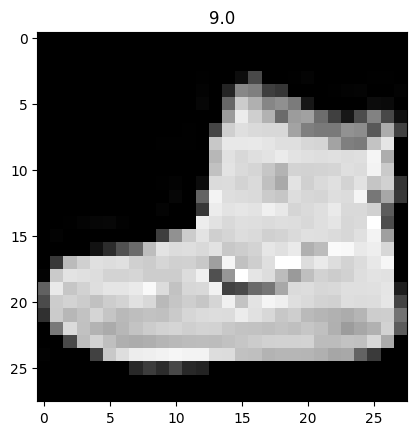

In [16]:
plt.imshow(X_train[0], cmap = 'binary_r')
plt.title(Y_train[0])

Obtenemos los pesos de la primer y segunda capa de convolución:

In [17]:
# Obtenemos la lista final de pesos completa.
CNN_weights = opt_get_weights(final_opt_state)

# Separamos los pesos por capa en una lista.
weights_list = []
for w in CNN_weights:
    if w:
        weights_list.append(w)

# Damos buen formato a los pesos.
corrected_weights_1 = [weights_list[0], ()]
corrected_weights_2 = [weights_list[1], ()]

print("Dimensiones de los pesos")
print("Capa 1: {}".format(corrected_weights_1[0][0].shape))
print("Capa 2: {}".format(corrected_weights_2[0][0].shape))

Dimensiones de los pesos
Capa 1: (3, 3, 1, 16)
Capa 2: (3, 3, 16, 8)


Definimos la primer y segunda capa de convolución nuevamente para posteriormente aplicarlas a la muestra:

In [18]:
# Definimos la primer convolución.
conv_init_1, conv_apply_1 = stax.serial(
    stax.Conv(16,(3,3), padding="SAME"),
    stax.Relu
)

# Definimos la segunda convolución.
conv_init_2, conv_apply_2 = stax.serial(
    stax.Conv(8,(3,3), padding="SAME"),
    stax.Relu
)

# Aplicamos la primer convolución.
trans_1 = conv_apply_1(corrected_weights_1, X_train[:1])

# Aplicamos la segunda convolución.
trans_2 = conv_apply_2(corrected_weights_2, trans_1)

print("Dimensiones de los resultados")
print("Capa 1: {}".format(trans_1.shape))
print("Capa 2: {}".format(trans_2.shape))

Dimensiones de los resultados
Capa 1: (1, 28, 28, 16)
Capa 2: (1, 28, 28, 8)


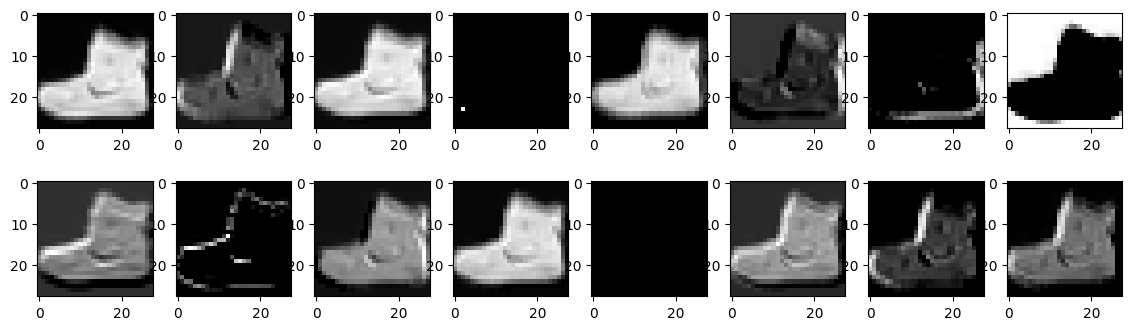

In [19]:
fig, ax = plt.subplots(2, 8, figsize=(14, 4))

img_num = 0
for i in range(0,2):
    for j in range(0,8):
        ax[i][j].imshow(trans_1[0,:,:,img_num], cmap = 'binary_r')
        img_num += 1

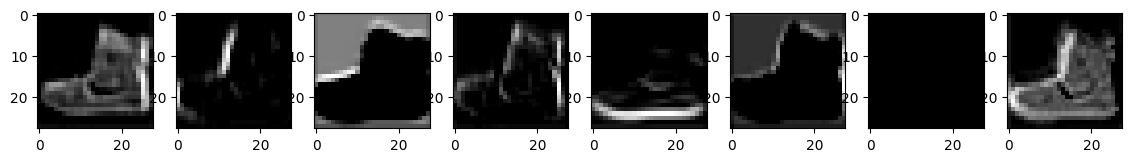

In [20]:
fig, ax = plt.subplots(1, 8, figsize=(14, 4))

img_num = 0
for i in range(0,8):
    ax[i].imshow(trans_2[0,:,:,img_num], cmap = 'binary_r')
    img_num += 1

______________________________________________

## Referencias

- https://jax.readthedocs.io/en/latest/quickstart.html
- https://coderzcolumn.com/tutorials/artificial-intelligence/jax-guide-to-create-convolutional-neural-networks
- https://coderzcolumn.com/tutorials/python/jax-numpy-and-automatic-gradients-on-accelerators-gpu-tpu#google_vignette